#Progress update - Chamain

Hello, we can you this page to share codes and update the progress.

- I found this [code](https://github.com/wikiabhi/Cifar-10/blob/master/cifar10_pca.ipynb). This code performs some tests we want (can be useful, not the most accurate.)
- keras CIFAR-10 code - [code](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py)
- Based on these two I stitched the following code. (very basic- need to optimize the network)



In [0]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 16 12:55:19 2019

@author: Lahiru D. Chamain
"""

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

batch_size = 32
num_classes = 10
epochs = 100
data_augmentation = True
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


#flattening for PCA
X_train = x_train.copy()
X_train = X_train.astype('float32')
x_train = x_train.reshape(x_train.shape[0],-1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32')
  
pca = PCA()
pca.fit_transform(x_train)

print('Original no of components: ',pca.explained_variance_.shape)

#Reduce the dimension to preserve 99% of the variance
# Calculating optimal k to have 95% (say) variance 

k = 0
total = sum(pca.explained_variance_)
current_sum = 0

while(current_sum / total < 0.99):
    current_sum += pca.explained_variance_[k]
    k += 1
numComp = k
print('reduced num of compoments: ',numComp)

#select only those compoments
## Applying PCA with k calcuated above

pca = PCA(n_components=k, whiten=True)

x_train_pca = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_test = x_test/np.max(np.abs(x_test))

print('done with PCA.')
print('shape of test: ',x_test.shape)

"""
print('KNN training')
#KNN
## Training 
knn = KNeighborsClassifier()
knn.fit(x_train_pca, y_train)

##predict
## Predicting
y_pred_knn = knn.predict(x_test_pca)

knn_score = accuracy_score(y_test, y_pred_knn)
print('K test score:',knn_score)
"""

#DenseNN
model = Sequential()
# For first layer, input shape must be supplied
layer1 = Dense(units = 50, activation = 'relu', input_dim = numComp)
model.add(layer1)

layer2 = Dense(units = 25, activation = 'relu')
model.add(layer2)

layer3 = Dense(units = num_classes, activation = 'sigmoid')
model.add(layer3)

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])


x_test = x_test.astype('float32')

def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 90:
        lr *= 1e-3
    elif epoch > 60:
        lr *= 1e-2
    elif epoch > 30:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

def creategen(X,Y,batch_size):
    while True:
        # suffled indices    
        #idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
                
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)

        batches= datagen.flow( X, Y, batch_size=batch_size,shuffle=True)
       
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            temp = batch[0].reshape(batch[0].shape[0],-1).astype('float32')
            temp = pca.transform(temp)
            yield  temp/np.max(np.abs(temp)), batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break


# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_model.{epoch:03d}.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

history_callback= model.fit_generator(creategen(X_train, y_train, batch_size=batch_size),
                                      steps_per_epoch=int(np.ceil(X_train.shape[0]/batch_size)),
                                      validation_data=(x_test, y_test),
                                      epochs=epochs, verbose=1, workers=1,
                                      callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
#print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
model.save('cdf97n_3R0model.h5')




Using TensorFlow backend.


170500096/170498071 [==============================] - 31s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
Original no of components:  (3072,)
reduced num of compoments:  658
done with PCA.
shape of test:  (10000, 658)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
Learning rate:  0.001
1563/1563 [==============================] - 51s 32ms/step - loss: 1.9946 - acc: 0.2768 - val_loss: 1.8546 - val_acc: 0.3486

Epoch 00001: val_acc improved from -inf to 0.34860, saving model to /content/saved_models/cifar10_model.001.h5
Epoch 2/100
Learning rate:  0.001
1563/1563 [==============================] - 50s 32ms/step - loss: 1.7528 - acc: 0.3806 - val_loss: 1.7727 - val_acc: 0.3851

Epoch 00002: val_acc improved from 0.34860 to 0.38510, saving model to /content/saved_models/cifar10_model.002.h5
Epoch 3/100
Learning rate:  0.001
1563/1563 [==============================] - 50s

KeyboardInterrupt: ignored

Results after 45 epochs
1. Network - (50,25,10), tr_acc = 53.16% val_acc = 49.42%,  tr_time = 30 s/epoch, parameters = 0.034M, comment = underfitting, need more paprameters
2. Network - (200,500,100,10), tr_acc = % val_acc = %,  tr_time = 30 s/epoch, parameters = M, comment = 

# RGB

In [0]:
#CNN for CIFAR10
#Zachary Cosenza

#import
import numpy as np
from sklearn.decomposition import PCA
from keras.datasets import cifar10
from keras import layers
from keras import models
from keras.utils import to_categorical
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt


def CrappyCNN(train_images,train_labels,test_images,test_labels):
    
    train_images = train_images.astype('float32') / max_image

    test_images = test_images.astype('float32') / max_image
    
    train_labels = to_categorical(train_labels)
    test_labels = to_categorical(test_labels)
    
    input_shape = train_images.shape[1:]
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    model.fit(train_images, train_labels, epochs=epoch_size, batch_size=batch_size)
    
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    return test_loss, test_acc


#Code for NN
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

image_size = 32
channel_num = 3
max_image = 255

epoch_size = 5
batch_size = 300

BWtest = HuffmanBW(test_images)
BWtrain = HuffmanBW(train_images)

plt.figure(1)
plt.bar('RGB',(BWtest+BWtrain)/2)
plt.xlabel('Method')
plt.ylabel('Bandwidth')
plt.title('BW for RGB')

test_loss_CNN, test_acc_CNN = CrappyCNN(train_images,train_labels,test_images,test_labels)

plt.figure(2)
plt.bar('RGB',test_acc_CNN)
plt.xlabel('Method')
plt.ylabel('Acc.')
plt.title('Acc. for RGB')

#fit model with PCA

train_images_pca = train_images.reshape(train_images.shape[0],-1).astype('float32')
test_images_pca = test_images.reshape(test_images.shape[0],-1).astype('float32')

pca = PCA(0.99)
pca.fit_transform(train_images_pca)

train_images_pca_proj = pca.fit_transform(train_images_pca)
train_images_recon = pca.inverse_transform(train_images_pca_proj)

train_images_recon = train_images_recon.reshape(train_images.shape).astype('float32')

test_images_pca_proj = pca.fit_transform(test_images_pca)
test_images_recon = pca.inverse_transform(test_images_pca_proj)

test_images_recon = test_images_recon.reshape(test_images.shape).astype('float32')

test_loss_CNN_PCA, test_acc_CNN_PCA = CrappyCNN(train_images_recon,train_labels,test_images_recon,test_labels)

BWtest_PCA = HuffmanBW(test_images_pca_proj)
BWtrain_PCA = HuffmanBW(train_images_pca_proj)

plt.figure(1)
plt.bar('RGB PCA',(BWtest_PCA+BWtrain_PCA)/2)

plt.figure(2)
plt.bar('RGB PCA',test_acc_CNN_PCA)

Using TensorFlow backend.


170500096/170498071 [==============================] - 28s 0us/step


NameError: ignored

# DCT

# DWT

Let's load the data set and calculate PCA components

In [0]:
#import libraries

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler



Using TensorFlow backend.


In [0]:
#DWT
from numpy.linalg import inv

def batchRGB2YCRCB(x_batch):
    alpha_R = 0.299
    alpha_G = 0.587
    alpha_B = 0.114
    x_batchnew = np.zeros((x_batch.shape)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        #Y
        x_batchnew[i,:,:,0] = alpha_R*x_batch[i,:,:,0] + alpha_G*x_batch[i,:,:,1] + alpha_B*x_batch[i,:,:,2]
        #Cb
        x_batchnew[i,:,:,1] = (0.5/(1-alpha_B))*(x_batch[i,:,:,2]-x_batchnew[i,:,:,0])
        #Cr
        x_batchnew[i,:,:,2] = (0.5/(1-alpha_R))*(x_batch[i,:,:,0]-x_batchnew[i,:,:,0])
    return x_batchnew

#CDF 9/7
def getTcdf97(height):
    a1 = -1.586134342
    a2 = -0.05298011854
    a3 = 0.8829110762
    a4 = 0.4435068522

    # Scale coeff:
    k1 = 0.8128662109 # 1/1.230174104914 // 0,2,4,6
    k2 = 0.6149902344 # 1.230174104914/2 // 5038 1,3,5,7
    X1 = np.identity(height)
    X2 = np.identity(height)
    X3 = np.identity(height)
    X4 = np.identity(height)
    X5 = np.zeros((height,height)).astype('float32')
    for col in range(1,height-2,2):
        X1[col-1,col]=X1[col+1,col]=a1
    X1[height-2,height-1] = 2*a1
    
    #print(X1)
    for col in range(2,height-1,2):
        X2[col-1,col]=X2[col+1,col]=a2
    X2[1,0] = 2*a2
    #print(X2)
    for col in range(1,height-2,2):
        X3[col-1,col]=X3[col+1,col]=a3
    X3[height-2,height-1] = 2*a3
    
    #print(X1)
    for col in range(2,height-1,2):
        X4[col-1,col]=X4[col+1,col]=a4
    X4[1,0] = 2*a4
    
    for col in range(0,height,1):
        if(col%2==0 ):
            #print(col)
            X5[col,int(col/2)]=k1
        else:
            X5[col,int(height/2 + (col-1)/2)]=k2
    #print(X3)
    X =np.matmul(np.matmul(np.matmul(np.matmul(X1,X2),X3),X4),X5)
    return X,inv(X)
  
# DWT transform
def batchwaveletcdf97mat(x_batch,X,dimhalf):
    x_batchnew = np.zeros((x_batch.shape[0],dimhalf,dimhalf,12)).astype('float32')
    for i in range(0,x_batch.shape[0]):
        for j in range(0,x_batch.shape[3]):
            coeff_array = np.matmul(np.matmul(X.transpose(),x_batch[i,:,:,j]),X)
            x_batchnew[i,:,:,j*4+0]=coeff_array[0:dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+1]=coeff_array[0:dimhalf,dimhalf:2*dimhalf]
            x_batchnew[i,:,:,j*4+2]=coeff_array[dimhalf:2*dimhalf,0:dimhalf]
            x_batchnew[i,:,:,j*4+3]=coeff_array[dimhalf:2*dimhalf,dimhalf:2*dimhalf]
    return x_batchnew

# BW calculation

In [0]:
#load the dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

#convert to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

#convert to DWT
#level offset
X_train = X_train - 128.0
X_test = X_test - 128.0


#RGB2YCbCr
X_train = batchRGB2YCRCB(X_train)
X_test = batchRGB2YCRCB(X_test)

M,M_inv = getTcdf97(32)

#DWT transform
X_train = batchwaveletcdf97mat(X_train,M,16)
X_test = batchwaveletcdf97mat(X_test,M,16)

#flattening for PCA
x_train_ori = X_train.copy()
x_train_ori = x_train_ori.astype('float32')
x_train = X_train.reshape(X_train.shape[0],-1).astype('float32')
x_test = X_test.reshape(X_test.shape[0], -1).astype('float32')

170500096/170498071 [==============================] - 6s 0us/step
x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


Calculate PCA and choose the components to preserve 99% of the variance - 658 components.

In [0]:
pca = PCA(0.99)
x_train_proj= pca.fit_transform(x_train)
x_train_proj = np.floor(x_train_proj/10)*10

x_test_proj= pca.transform(x_test)
x_test_proj = np.floor(x_test_proj/10)*10


print('original representation',x_train.shape)
print('reduced representation: ',x_train_proj.shape)


original representation (50000, 3072)
reduced representation:  (50000, 687)


In [0]:
print(pca.components_[0,:])
print(x_train_proj)

[ 1.0042940e-01 -7.9095364e-05  2.6768446e-04 ...  1.3978239e-05
  3.5628349e-05 -2.3968446e-06]
[[-410.  270.   90. ...  -10.  -10.    0.]
 [  50.  -60.  420. ...   10.    0.    0.]
 [ 620. -860. -160. ...    0.  -10.  -10.]
 ...
 [  50. -870.   10. ...  -10.    0.  -10.]
 [ 800. -200.  400. ...    0.  -10.  -10.]
 [ 320. -120. -340. ...  -10.    0.  -20.]]


Display the first few princiapal components

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

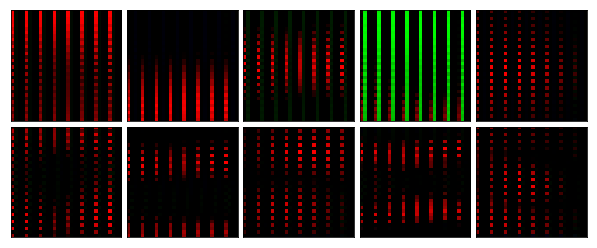

In [0]:
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
  ax.imshow(np.reshape(pca.components_[i,:]/np.max(pca.components_[i,:]), (32,32,3)), cmap=plt.cm.bone, interpolation='nearest')

Now recontruct the images after dim reduction

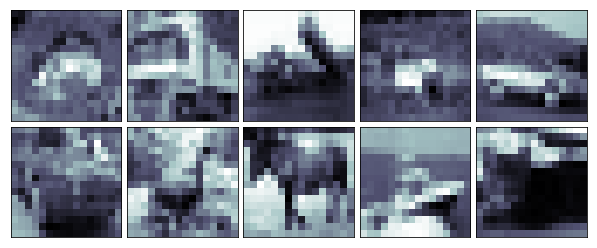

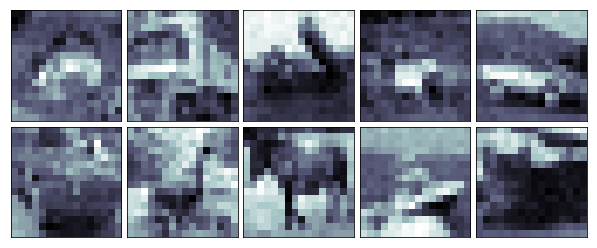

In [0]:
x_train_recon = pca.inverse_transform(x_train_proj)
x_train_recon = x_train_recon.reshape(X_train.shape)

x_test_recon = pca.inverse_transform(x_test_proj)
x_test_recon = x_test_recon.reshape(X_test.shape)

#show original images
#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
  ax.imshow(np.reshape(x_train_ori[i,:,:,0]/np.max(x_train_ori[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  
#recon images
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
# plot the components, each image is 26 by 26 pixels
for i in range(10):
  ax = fig.add_subplot(5, 5, i+1, xticks=[], yticks=[])
  ax.imshow(np.reshape(x_train_recon[i,:,:,0]/np.max(x_train_recon[i,:,:,0]), (16,16)), cmap=plt.cm.bone, interpolation='nearest')
  

Lets compare the BW of roginal and reduced train sets.

In [0]:
zeros,BW = HuffmanBW(np.floor(x_train_ori).astype('int32'))
print('Original images: % of zeros = ',str(zeros*100),' and BW: ',str(BW),' Bits')
zerosr,BWr = HuffmanBW(np.floor(x_train_recon).astype('int32'))
print('reduced images: % of zeros = ',str(zerosr*100),' and BW: ',str(BWr),' Bits')
#projections
zerosp,BWp = HuffmanBW(np.floor(x_train_proj/10).astype('int32'))
print('reduced images: % of zeros = ',str(zerosp*100),' and BW: ',str(BWp),' Bits')

Original images: % of zeros =  27.667077473958336  and BW:  12417.0  Bits
reduced images: % of zeros =  28.055281250000004  and BW:  12619.0  Bits
reduced images: % of zeros =  31.283828238719067  and BW:  1915.0  Bits


In [0]:
from heapq import heappush, heappop, heapify
from collections import defaultdict
import numpy as np
import copy
from tqdm import tqdm
def encode(symb2freq):
    """Huffman encode the given dict mapping symbols to weights"""
    heap = [[wt, [sym, ""]] for sym, wt in symb2freq.items()]
    heapify(heap)
    while len(heap) > 1:
        lo = heappop(heap)
        hi = heappop(heap)
        for pair in lo[1:]:
            pair[1] = '0' + pair[1]
        for pair in hi[1:]:
            pair[1] = '1' + pair[1]
        heappush(heap, [lo[0] + hi[0]] + lo[1:] + hi[1:])
    return sorted(heappop(heap)[1:], key=lambda p: (len(p[-1]), p))
  
  



layer=0
nbits=3


####################################################Assume the dataset you want to calculate the average BW is x_test
def HuffmanBW(x_test):
  bitstream=0
  for imnum in range(0,x_test.shape[0]):
  #for imnum in tqdm(range(0,1)):
      img = x_test[imnum,]
      #print(img.shape)
      bitcount=0


      if(np.min(img) < 0):
          img = img - np.min(img)
      if(np.max(img)==0):
          img[0,0]=1

      txt = "".join(map(chr, img.flatten()))

      symb2freq = defaultdict(int)
      for ch in txt:
          symb2freq[ch] += 1
      # in Python 3.1+:
      # symb2freq = collections.Counter(txt)
      huff = encode(symb2freq)
      #print("Symbol\tWeight\tHuffman Code")
      #for p in huff:
      #    print("%s\t%s\t%s" % (p[0], symb2freq[p[0]], p[1]))

      ##### Calculating the number of bits needed

      for p in huff:
          bitcount = bitcount+  symb2freq[p[0]]*len(p[1])
      bitstream = bitstream + bitcount
      input_bits = len(img.flatten())*nbits
      #compression = compression + (1-bitcount/input_bits)*100	# compression rate

  
  BW = np.round(bitstream/x_test.shape[0])            ## BW in bits
  

  return np.mean(x_test==0.0),BW


# ResNet-20

In [0]:
#Resnet-20
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
import tensorflow as tf
from keras.models import Model
import time

n=3


# Computed depth from supplied model parameter n

depth = n * 6 + 2

# Model name, depth and version
model_type = 'ResNet%d' % (depth)

def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3, ######################### try to change this and see
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 64 #################################################################### changed ori:16
    num_res_blocks = int((depth - 2) / 6)#2############################################################### changed ori: int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters  = int(num_filters*1.5)

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=4)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [0]:
#data augmentation
def creategen(X,Y,batch_size):
    while True:
        # suffled indices    
        #idx = np.random.permutation( X.shape[0])
        # create image generator
        datagen = ImageDataGenerator(
                
                featurewise_center=False,  # set input mean to 0 over the dataset
                samplewise_center=False,  # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                samplewise_std_normalization=False,  # divide each input by its std
                zca_whitening=False,  # apply ZCA whitening
                rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False)

        batches= datagen.flow( X, Y, batch_size=batch_size,shuffle=True)
       
        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]
            temp = batch[0].astype('float32')
            #waveletmy2.batchwaveletcdf97mat(batch[0].astype('float32'),M,16)
            #temp = waveletmy2.batchwaveletsArrange(temp)
            
            yield temp/np.max(np.abs(temp)) , batch[1]

            idx0 = idx1
            if idx1 >= X.shape[0]:
                break

In [0]:
#Let's train

batch_size = 32  # orig paper trained all networks with batch_size=128
epochs = 200
data_augmentation = True
num_classes = 10


x_test=x_test_recon/np.max(np.abs(x_test_recon))
print('test shape:',x_test.shape)
print('train shape:',x_train_recon.shape)


input_shape = x_test.shape[1:]

#training a Resnet-20

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-2
    elif epoch > 160:
        lr *= 1e-2
    elif epoch > 120:
        lr *= 1e-1
    elif epoch > 80:
        lr *= 0.5
    print('Learning rate: ', lr)
    return lr
                
model = resnet_v1(input_shape=input_shape, depth=depth)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# Fit the model on the batches generated by datagen.flow().
model.fit_generator(creategen(x_train_recon, y_train, batch_size=batch_size),
                    steps_per_epoch=int(np.ceil(x_train_recon.shape[0]/32.0)),
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1, workers=1,
                    callbacks=callbacks)
start = time.time()
# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('time per image :',(time.time()-start)*1000/10000,' ms')
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])



test shape: (10000, 16, 16, 12)
train shape: (50000, 16, 16, 12)
Instructions for updating:
Colocations handled automatically by placer.
Learning rate:  0.001
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 16, 16, 12)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   6976        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 16, 16, 64

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (50000, 16, 16, 12) (12 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Learning rate:  0.001
1487/1563 [===========================>..] - ETA: 1:10 - loss: 1.9106 - acc: 0.4569